In [153]:
## Celda 1: Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import learning_curve
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import friedmanchisquare
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configuración para visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [154]:
#Cargar el dataset 
df = pd.read_csv('autos.csv')

selected_features = ['displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
df = df[selected_features + ['MPG']]  #MPG es la variable objetivo,son millas por galón de combustible


In [155]:
#Descripcion del dataset
#The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 2 multivalued discrete and 4 continuous attributes
#El archivo esta cargado en mi github!!
#fuente https://archive.ics.uci.edu/dataset/9/auto+mpg con cantidad de features reducida.He aquí las variables que se han seleccionado para el análisis:
''''
    1. mpg:           continuous   (target variable)
    
    2. displacement:  continuous
    3. horsepower:    continuous
    4. weight:        continuous
    5. acceleration:  continuous
    6. model year:    multi-valued discrete
    7. origin:        multi-valued discrete
    
'''
#Omití variables categoricas como nombre del auto, optaré por variables numéricas continuas y discretas.

"'\n    1. mpg:           continuous   (target variable)\n\n    2. displacement:  continuous\n    3. horsepower:    continuous\n    4. weight:        continuous\n    5. acceleration:  continuous\n    6. model year:    multi-valued discrete\n    7. origin:        multi-valued discrete\n\n"

=== INFORMACIÓN DEL DATASET ===
Tamaño del dataset: (2000, 7)

=== ESTADÍSTICAS DESCRIPTIVAS ===
       displacement   horsepower       weight  acceleration         year  \
count   2000.000000  2000.000000  2000.000000   2000.000000  2000.000000   
mean     261.975218   137.335831  3287.368680     15.805436    76.200500   
std      112.501157    53.098701   978.999572      4.597029     3.748376   
min       71.239031    46.002141  1600.104444      8.003856    70.000000   
25%      161.647892    92.144764  2439.579449     11.829282    73.000000   
50%      265.330239   136.655756  3271.136537     15.747181    76.000000   
75%      359.011350   183.759054  4115.496046     19.794138    79.000000   
max      454.891304   229.918617  4997.791022     23.991371    82.000000   

            origin          MPG  
count  2000.000000  2000.000000  
mean      1.996500    46.742194  
std       0.811059     4.939486  
min       1.000000    31.603302  
25%       1.000000    43.344253  
50%       2.00

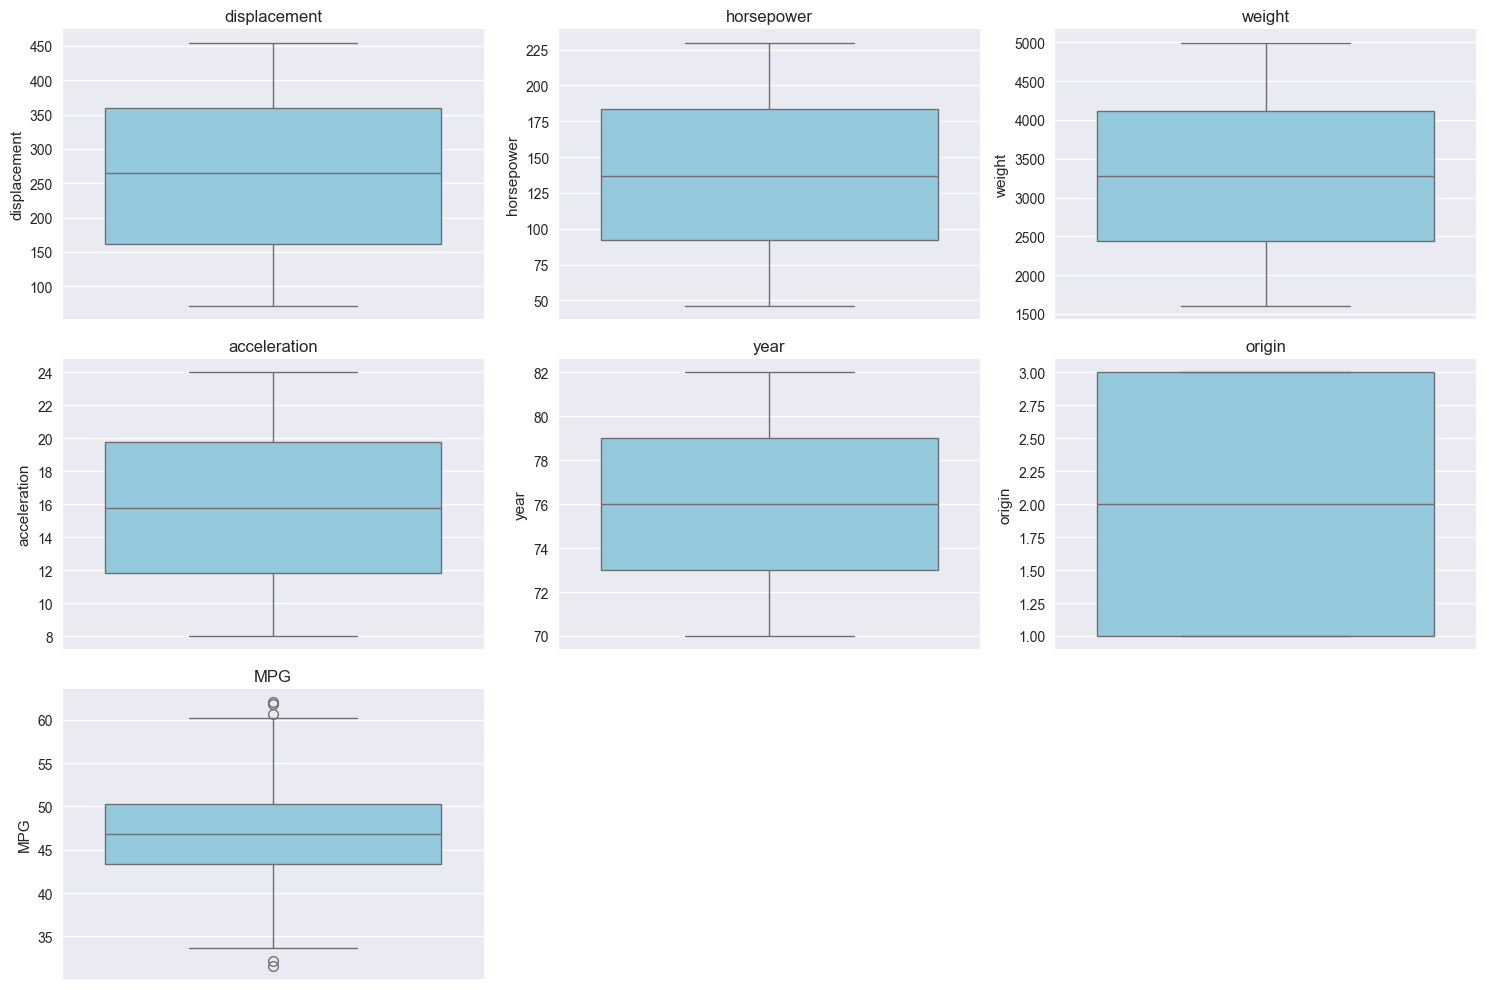

In [156]:
# Información del dataset
print('=== INFORMACIÓN DEL DATASET ===')
print(f'Tamaño del dataset: {df.shape}')

# Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())

# Información general del dataset
print("\n=== INFO GENERAL ===")
print(df.info())

# Revisión de valores faltantes
print("=== VALORES FALTANTES ===")
print(df.isnull().sum())


# Boxplots para detectar outliers visualmente

plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, y=column, color="skyblue")
    plt.title(column)
plt.tight_layout()
plt.show()


In [157]:
#Notemos que no hay missing values.
#Ahora que hemos visualizado los datos:
#Vamos a detectar outliers usando el método IQR (Rango Intercuartílico)
#Se lo aplico a la variable objetivo 'MPG' pues es la unica que evidencia outliers en el boxplot
#Utilizo el método IQR para detectar outliers

Q1 = df['MPG'].quantile(0.25)
Q3 = df['MPG'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df['MPG'] < (Q1 - 1.5 * IQR)) |
                (df['MPG'] > (Q3 + 1.5 * IQR)))
print(f"Number of outliers detected by IQR method: {np.sum(outliers_iqr)}")



Number of outliers detected by IQR method: 5


In [158]:
#La cantidad de outliers detectados por el método IQR es 5,vamos a transformar la variable objetivo 'MPG' usando la transformación Box-Cox
#He decidido no eliminarlos porque no son muchos y la variable objetivo es importante para el modelo.
#Ademas, no parecen ser outliers extremos, por lo que la transformación Box-Cox puede ayudar a normalizar la distribución sin eliminarlos.
#Esta columna,tal como se evidencia en el boxplot,no tiene valores negativos, por lo que la transformación Box-Cox es adecuada.

mpg = df["MPG"]
df["MPG_boxcox"], fitted_lambda = boxcox(mpg)
print("Lambda:", fitted_lambda)



Lambda: 1.1013813311942027


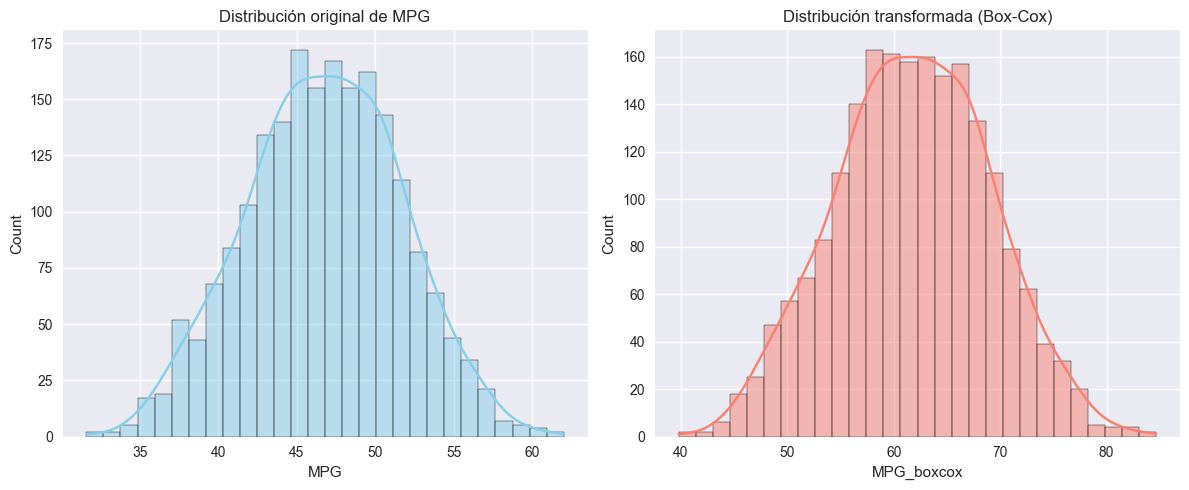

In [159]:
# Se realizó la transformación Box-Cox sobre la variable 'MPG' para mejorar su normalidad.
# El valor de lambda estimado fue 1.10, lo cual está muy cerca de 1 (la identidad),
# indicando que la distribución original no requería una transformación significativa.
# Por este motivo, se opta por continuar con los datos originales sin aplicar la transformación.

# Visualización de la distribución original y transformada


plt.figure(figsize=(12, 5))

# Original
plt.subplot(1, 2, 1)
sns.histplot(df["MPG"], kde=True, color='skyblue')
plt.title("Distribución original de MPG")

# Box-Cox
plt.subplot(1, 2, 2)
sns.histplot(df["MPG_boxcox"], kde=True, color='salmon')
plt.title("Distribución transformada (Box-Cox)")

plt.tight_layout()
plt.show()


In [160]:
# Se elimina la columna 'MPG_boxcox' ya que se decidió continuar con los datos originales,
# debido a que la transformación no fue necesaria (lambda ≈ 1).
df.drop(columns=["MPG_boxcox"], inplace=True)


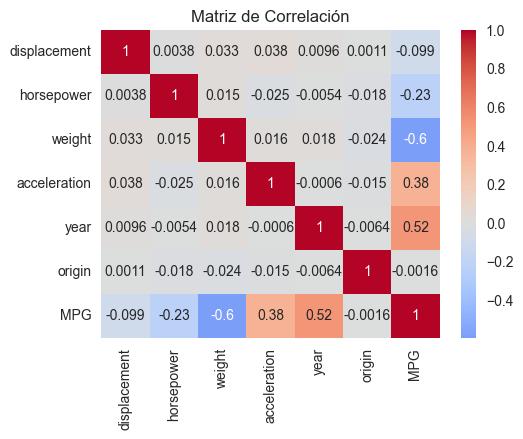

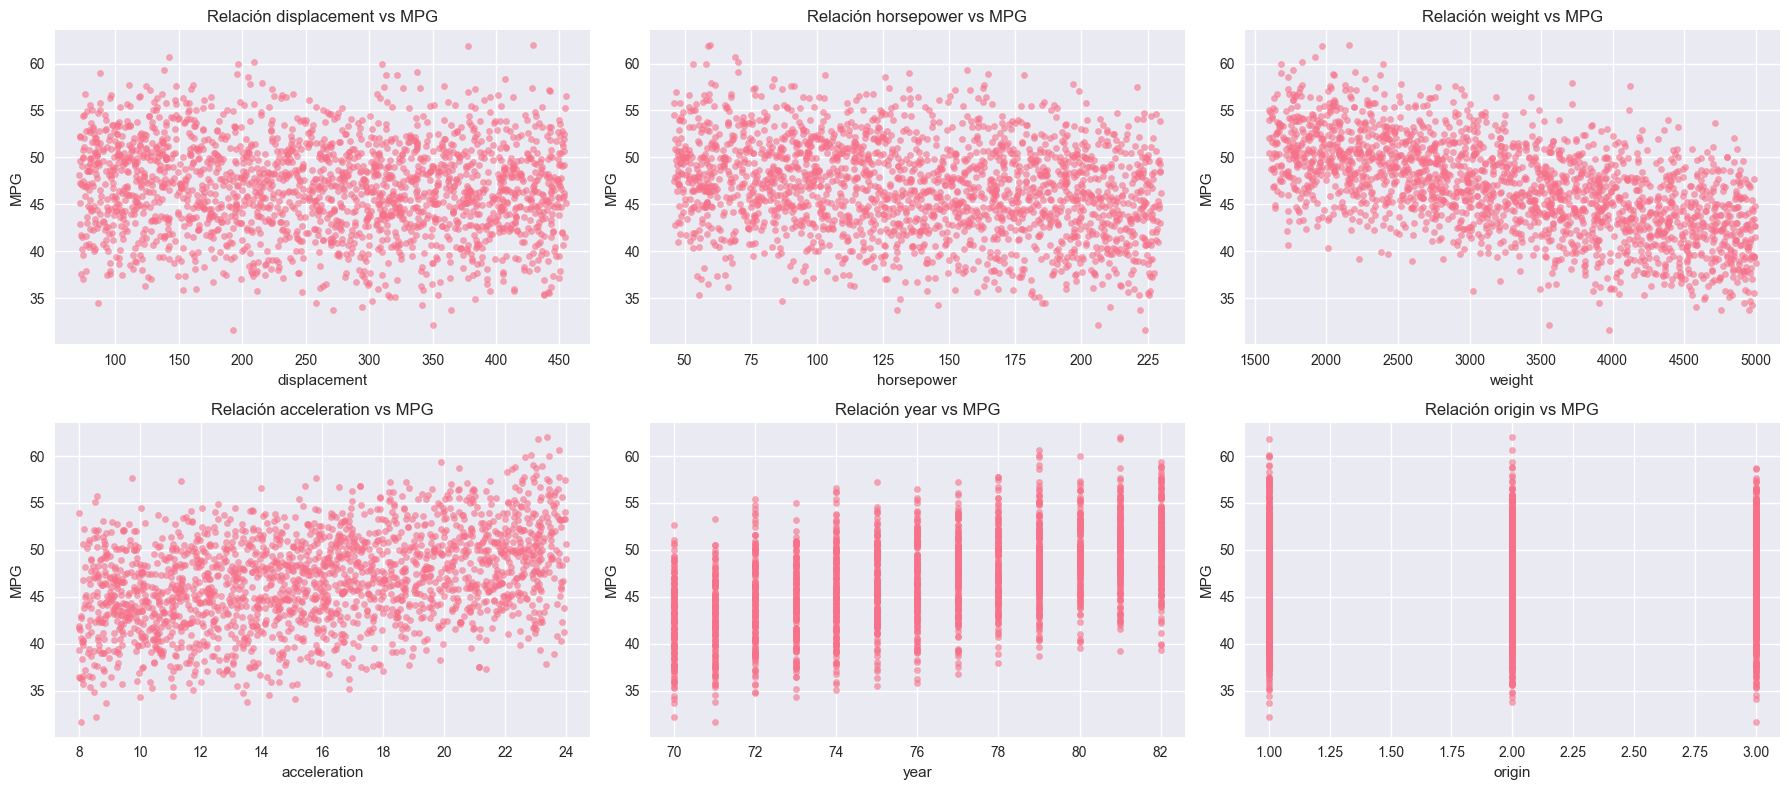

In [161]:
# Visualización de correlaciones


plt.figure(figsize=(12, 4))

# Matriz de correlación
plt.subplot(1, 2, 1)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')

#Dispersión de todas las features contra el target
cols = 3
rows = (len(selected_features) + cols - 1) // cols  # en este caso, 2 filas

plt.figure(figsize=(cols * 6, rows * 4))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(df[feature], df['MPG'], alpha=0.6, s=20)
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.title(f'Relación {feature} vs MPG')

plt.tight_layout()
plt.show()



In [162]:
# Celda 3: Preparación de datos para modelado

# Separar características y variable objetivo
X = df.drop('MPG', axis=1)
y = df['MPG']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Estandarización (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== PREPARACIÓN DE DATOS ===")
print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")
print(f"Rango de y_train: [{y_train.min():.2f}, {y_train.max():.2f}]")


=== PREPARACIÓN DE DATOS ===
Tamaño entrenamiento: (1600, 6)
Tamaño prueba: (400, 6)
Rango de y_train: [31.60, 62.01]


In [163]:
#Diagnostico de supuestos para regresion

X = df[selected_features]
y = df['MPG']

# Agregar constante (intercepto)
X = sm.add_constant(X)

# Ajustar el modelo OLS
model = sm.OLS(y, X).fit()

#Heterocedasticidad
bp_stat, bp_p, _, _ = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan p-valor: {bp_p:.4f} - {'HETEROCEDASTICIDAD' if bp_p < 0.05 else 'HOMOCEDASTICIDAD'}")

# Multicolinealidad

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(f"\nFactor de Inflación de Varianza:")
print(vif_data)


# Normalidad
_, shapiro_p_real = stats.shapiro(model.resid)
print(f"\nShapiro-Wilk p-valor: {shapiro_p_real:.4f} - {'NO NORMAL' if shapiro_p_real < 0.05 else 'NORMAL'}")

Breusch-Pagan p-valor: 0.2519 - HOMOCEDASTICIDAD

Factor de Inflación de Varianza:
        feature         VIF
0         const  453.743499
1  displacement    1.002575
2    horsepower    1.001247
3        weight    1.002377
4  acceleration    1.002565
5          year    1.000472
6        origin    1.001129

Shapiro-Wilk p-valor: 0.7608 - NORMAL


In [164]:
print('''Se evaluaron los supuestos clásicos del modelo para asegurar la validez de los resultados:

#La prueba de Breusch-Pagan para homocedasticidad arrojó un p-valor de 0.2519, lo que indica que no hay evidencia suficiente para rechazar la hipótesis de varianza constante de los errores. Por lo tanto, se cumple el supuesto de homocedasticidad.

#El análisis del Factor de Inflación de Varianza (VIF) muestra valores muy bajos para todas las variables independientes (todos alrededor de 1), lo que sugiere que no existe multicolinealidad problemática entre las variables predictoras.

#La prueba de Shapiro-Wilk aplicada a los residuos reportó un p-valor de 0.7608, indicando que no se rechaza la normalidad de los residuos. Esto permite asumir que los errores siguen una distribución normal, cumpliendo con ese supuesto.

Dado que los supuestos principales se cumplen, se considera apropiado continuar con el modelado y análisis inferencial utilizando regresión lineal múltiple.''')

Se evaluaron los supuestos clásicos del modelo para asegurar la validez de los resultados:

#La prueba de Breusch-Pagan para homocedasticidad arrojó un p-valor de 0.2519, lo que indica que no hay evidencia suficiente para rechazar la hipótesis de varianza constante de los errores. Por lo tanto, se cumple el supuesto de homocedasticidad.

#El análisis del Factor de Inflación de Varianza (VIF) muestra valores muy bajos para todas las variables independientes (todos alrededor de 1), lo que sugiere que no existe multicolinealidad problemática entre las variables predictoras.

#La prueba de Shapiro-Wilk aplicada a los residuos reportó un p-valor de 0.7608, indicando que no se rechaza la normalidad de los residuos. Esto permite asumir que los errores siguen una distribución normal, cumpliendo con ese supuesto.

Dado que los supuestos principales se cumplen, se considera apropiado continuar con el modelado y análisis inferencial utilizando regresión lineal múltiple.


In [165]:
# Celda 4: Implementación de Regresión Lineal Múltiple
print('=== REGRESIÓN LINEAL MÚLTIPLE ===')

# Entrenar modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Métricas
lr_train_mse = mean_squared_error(y_train, y_pred_lr_train)
lr_test_mse = mean_squared_error(y_test, y_pred_lr_test)
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print(f'MSE Entrenamiento: {lr_train_mse:.4f}')
print(f'MSE Prueba: {lr_test_mse:.4f}')
print(f'R² Entrenamiento: {lr_train_r2:.4f}')
print(f'R² Prueba: {lr_test_r2:.4f}')

# Coeficientes
print(f'\nCoeficientes del modelo:')
feature_names = selected_features
for coef, name in zip(lr_model.coef_, feature_names):
    print(f'  {name}: {coef:.4f}')
print(f'  Intercepto: {lr_model.intercept_:.4f}')


#Analizo significancia de los coeficientes
X = sm.add_constant(df[selected_features])
y = df['MPG']

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


=== REGRESIÓN LINEAL MÚLTIPLE ===
MSE Entrenamiento: 3.9270
MSE Prueba: 4.3027
R² Entrenamiento: 0.8388
R² Prueba: 0.8244

Coeficientes del modelo:
  displacement: -0.0045
  horsepower: -0.0200
  weight: -0.0030
  acceleration: 0.4166
  year: 0.6971
  origin: -0.0786
  Intercepto: 1.1607
                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1693.
Date:                Fri, 18 Jul 2025   Prob (F-statistic):               0.00
Time:                        01:40:03   Log-Likelihood:                -4224.2
No. Observations:                2000   AIC:                             8462.
Df Residuals:                    1993   BIC:                             8502.
Df Model:                           6                                         


In [166]:
print("ANALISIS DE SIGNIFICANCIA DE LOS COEFICIENTES")
print('''
Las variables displacement, horsepower, weight, acceleration y year presentan p-valores inferiores a 0.05, 
lo que indica que sus coeficientes son estadísticamente significativos al nivel del 5%. 
Esto sugiere que estas variables tienen una relación significativa con la variable objetivo (MPG).
      
Por el contrario, la variable origin presenta un p-valor de 0.255, lo cual indica que no es estadísticamente significativa en el modelo, es decir, 
no se puede afirmar con evidencia suficiente que tenga un efecto distinto de cero sobre MPG en presencia de las demás variables.''')

print("-" * 80)
print("ANALISIS DE RESULTADOS OBTENIDOS")
print('''
Los resultados indican un buen ajuste del modelo, con un error cuadrático medio (MSE) de 3.9270 en el conjunto de entrenamiento y 4.3027 en el conjunto de prueba. 
Esto sugiere que el modelo predice con precisión razonable tanto los datos usados para entrenar como los datos nuevos.
      
El coeficiente de determinación 𝑅^2 es 0.8388 en entrenamiento y 0.8244 en prueba, lo que significa que aproximadamente el 83-84% de la variabilidad en MPG 
se explica por las variables independientes incluidas en el modelo. Esto denota una capacidad explicativa alta.
      
displacement, horsepower y weight tienen coeficientes negativos , indicando que a medida que estas variables aumentan, el consumo de combustible (MPG) tiende a disminuir,manteniendo constantes las demás variables.
Por otro lado, acceleration y year tienen coeficientes positivos, lo que sugiere que un aumento en estas variables está asociado con un mayor consumo de combustible (MPG), manteniendo constantes las demás variables.
origin tiene un coeficiente negativo (-0.0630), pero no resulta estadísticamente significativo (p=0.255), lo que indica que no se puede afirmar con evidencia suficiente que tenga un efecto distinto de cero sobre MPG en presencia de las demás variables.

Finalmente, el estadístico Durbin-Watson (2.036) sugiere que no existe autocorrelación significativa en los residuos, y las pruebas de normalidad (Omnibus y Jarque-Bera) no rechazan la normalidad de los residuos.
      
''')

ANALISIS DE SIGNIFICANCIA DE LOS COEFICIENTES

Las variables displacement, horsepower, weight, acceleration y year presentan p-valores inferiores a 0.05, 
lo que indica que sus coeficientes son estadísticamente significativos al nivel del 5%. 
Esto sugiere que estas variables tienen una relación significativa con la variable objetivo (MPG).

Por el contrario, la variable origin presenta un p-valor de 0.255, lo cual indica que no es estadísticamente significativa en el modelo, es decir, 
no se puede afirmar con evidencia suficiente que tenga un efecto distinto de cero sobre MPG en presencia de las demás variables.
--------------------------------------------------------------------------------
ANALISIS DE RESULTADOS OBTENIDOS

Los resultados indican un buen ajuste del modelo, con un error cuadrático medio (MSE) de 3.9270 en el conjunto de entrenamiento y 4.3027 en el conjunto de prueba. 
Esto sugiere que el modelo predice con precisión razonable tanto los datos usados para entrenar como

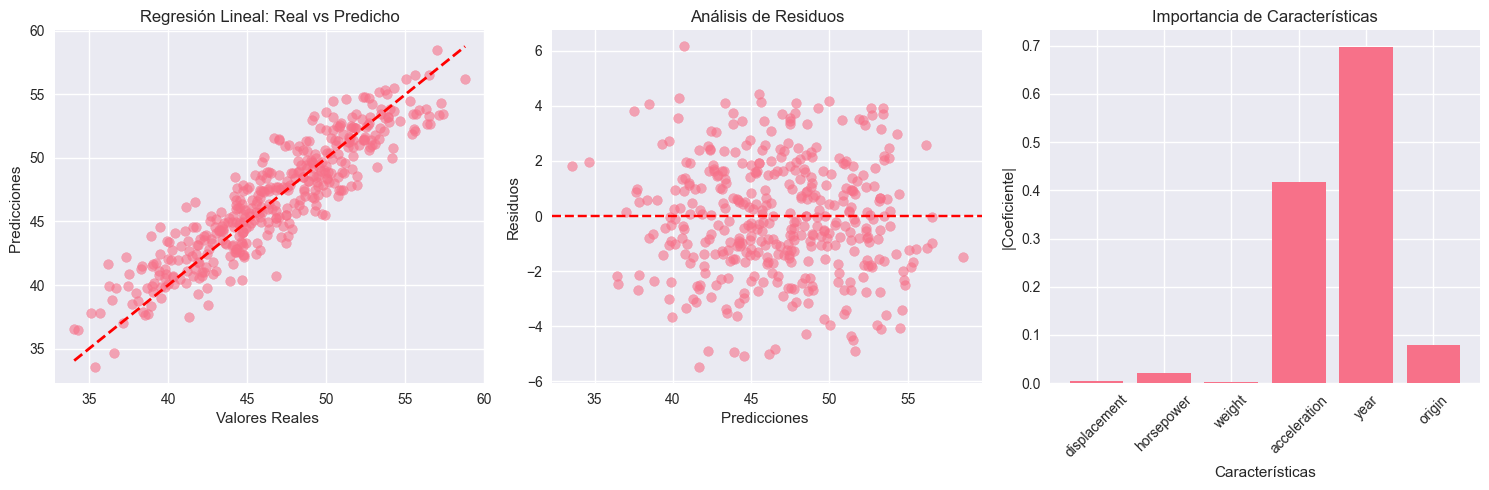

In [167]:
# Celda 5: Análisis de Regresión Lineal

# Visualización de resultados
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales ')
plt.ylabel('Predicciones ')
plt.title('Regresión Lineal: Real vs Predicho')

# Gráfico 2: Residuos
plt.subplot(1, 3, 2)
residuals_lr = y_test - y_pred_lr_test
plt.scatter(y_pred_lr_test, residuals_lr, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones ')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')

# Gráfico 3: Importancia de características (coeficientes)
plt.subplot(1, 3, 3)
feature_names = selected_features
feature_importance = abs(lr_model.coef_)
plt.bar(feature_names, feature_importance)
plt.xlabel('Características')
plt.ylabel('|Coeficiente|')
plt.title('Importancia de Características')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [168]:
# Celda 6: Implementación de Árbol de Regresión
# Entrenar modelo con diferentes profundidades para encontrar la óptima
depths = [3, 5, 7, 10, 15, 20]
best_depth = 0
best_score = float('-inf')

for depth in depths:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_temp, X_train, y_train, cv=5, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_depth = depth

print(f"Mejor profundidad encontrada: {best_depth}")        
# Entrenar modelo final
tree_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)

# Métricas
tree_train_mse = mean_squared_error(y_train, y_pred_tree_train)
tree_test_mse = mean_squared_error(y_test, y_pred_tree_test)
tree_train_r2 = r2_score(y_train, y_pred_tree_train)
tree_test_r2 = r2_score(y_test, y_pred_tree_test)

print(f"MSE Entrenamiento: {tree_train_mse:.4f}")
print(f"MSE Prueba: {tree_test_mse:.4f}")
print(f"R² Entrenamiento: {tree_train_r2:.4f}")
print(f"R² Prueba: {tree_test_r2:.4f}")

Mejor profundidad encontrada: 7
MSE Entrenamiento: 3.2804
MSE Prueba: 8.5879
R² Entrenamiento: 0.8653
R² Prueba: 0.6496


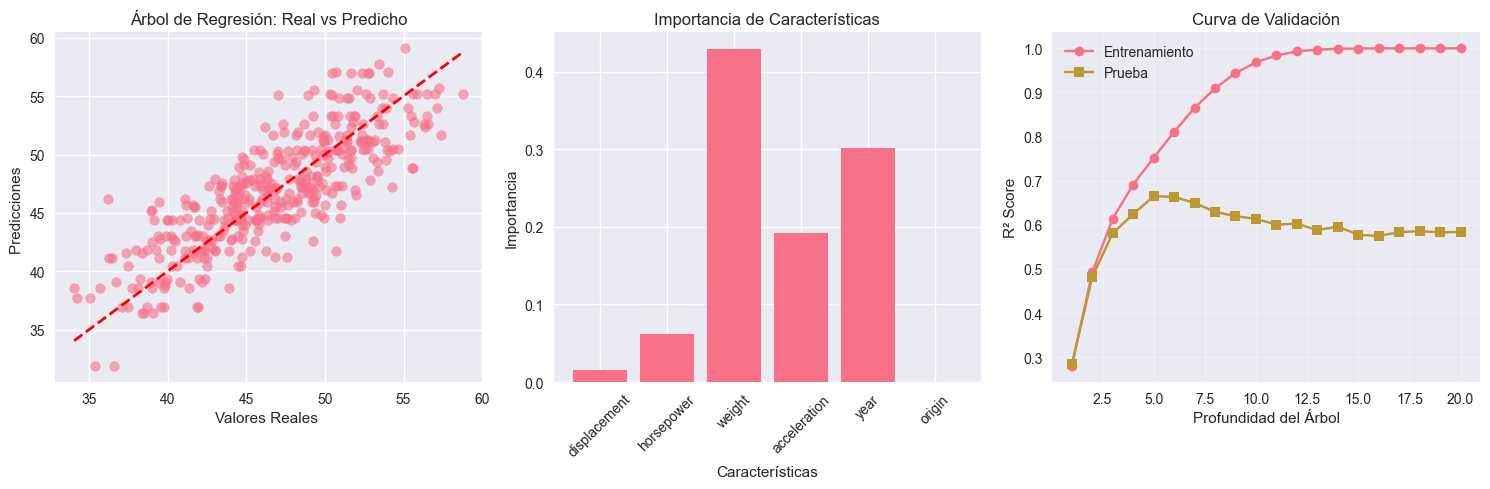

displacement: 0.0151
horsepower: 0.0620
weight: 0.4291
acceleration: 0.1920
year: 0.3016
origin: 0.0002


In [169]:
# Celda 7: Análisis de Árbol de Regresión
# Visualización de resultados
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_tree_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales ')
plt.ylabel('Predicciones ')
plt.title('Árbol de Regresión: Real vs Predicho')

# Gráfico 2: Importancia de características
plt.subplot(1, 3, 2)
feature_names = selected_features
feature_importance = tree_model.feature_importances_
plt.bar(feature_names, feature_importance)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características')
plt.xticks(rotation=45)

# Gráfico 3: Análisis de profundidad
plt.subplot(1, 3, 3)
depths_analysis = range(1, 21)
train_scores = []
test_scores = []

for depth in depths_analysis:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_temp.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, tree_temp.predict(X_train)))
    test_scores.append(r2_score(y_test, tree_temp.predict(X_test)))

plt.plot(depths_analysis, train_scores, label='Entrenamiento', marker='o')
plt.plot(depths_analysis, test_scores, label='Prueba', marker='s')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('R² Score')
plt.title('Curva de Validación')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for name, importance in zip(feature_names, feature_importance):
    print(f"{name}: {importance:.4f}")


In [170]:
print("ANALISIS DE IMPORTANCIA DE CARACTERISTICAS")
print("")

print("En nuestro grafico de importancia de características, podemos observar que:")
print('''
#La variable más influyente fue weight, con una importancia de aproximadamente 0.43. Esto indica que el peso del vehículo es el factor que más contribuye a explicar el consumo de combustible en el modelo, lo cual es coherente ya que vehículos más pesados tienden a consumir más combustible.

#La segunda variable en importancia fue year (0.30), lo que sugiere que el año de fabricación tiene un impacto considerable en la eficiencia del vehículo.

#En tercer lugar aparece acceleration (0.19), lo cual indica que la capacidad de aceleración del vehículo también tiene un peso relevante en la predicción del consumo.

#horsepower (0.06) y displacement (0.015) tienen menor peso en el modelo. Finalmente, origin (0.0002) resultó prácticamente irrelevante, lo que indica que el país o región de fabricación no tiene impacto significativo en la predicción de MPG en este conjunto de datos.

En resumen, el modelo identifica al peso, al año de fabricación y a la aceleración como los factores más determinantes para predecir el consumo de combustible. ''')

ANALISIS DE IMPORTANCIA DE CARACTERISTICAS

En nuestro grafico de importancia de características, podemos observar que:

#La variable más influyente fue weight, con una importancia de aproximadamente 0.43. Esto indica que el peso del vehículo es el factor que más contribuye a explicar el consumo de combustible en el modelo, lo cual es coherente ya que vehículos más pesados tienden a consumir más combustible.

#La segunda variable en importancia fue year (0.30), lo que sugiere que el año de fabricación tiene un impacto considerable en la eficiencia del vehículo.

#En tercer lugar aparece acceleration (0.19), lo cual indica que la capacidad de aceleración del vehículo también tiene un peso relevante en la predicción del consumo.

#horsepower (0.06) y displacement (0.015) tienen menor peso en el modelo. Finalmente, origin (0.0002) resultó prácticamente irrelevante, lo que indica que el país o región de fabricación no tiene impacto significativo en la predicción de MPG en este conjunto de 

In [171]:
print('Estudio de underfitting y overfitting')
print('')
print('''
En el análisis del modelo de árbol de regresión, se observa una diferencia significativa entre el desempeño en el conjunto de entrenamiento y en el conjunto de prueba. 
Con una profundidad óptima encontrada de 7, el modelo alcanza un 𝑅^2 de 0.8653 en entrenamiento, pero cae a 0.6496 en prueba.Este comportamiento indica la presencia de overfitting.
La diferencia entre el rendimiento en entrenamiento y prueba sugiere que el modelo ha aprendido patrones específicos del conjunto de entrenamiento, pero no generaliza bien a datos nuevos.
      
      ''')

print('''Para controlar el sobreajuste, aplico poda previa, limitando la profundidad y el tamaño mínimo de los nodos durante la construcción del árbol. 
Además,uso validación cruzada para elegir los mejores hiperparámetros y asegurar buena generalización. ''')

Estudio de underfitting y overfitting


En el análisis del modelo de árbol de regresión, se observa una diferencia significativa entre el desempeño en el conjunto de entrenamiento y en el conjunto de prueba. 
Con una profundidad óptima encontrada de 7, el modelo alcanza un 𝑅^2 de 0.8653 en entrenamiento, pero cae a 0.6496 en prueba.Este comportamiento indica la presencia de overfitting.
La diferencia entre el rendimiento en entrenamiento y prueba sugiere que el modelo ha aprendido patrones específicos del conjunto de entrenamiento, pero no generaliza bien a datos nuevos.

      
Para controlar el sobreajuste, aplico poda previa, limitando la profundidad y el tamaño mínimo de los nodos durante la construcción del árbol. 
Además,uso validación cruzada para elegir los mejores hiperparámetros y asegurar buena generalización. 


In [172]:
#Aplico poda previa al árbol de regresión para controlar el sobreajuste
print('=== PODA PREVIA DEL ÁRBOL DE REGRESIÓN ===')
# Definir rangos para hiperparámetros de poda previa
param_grid = {
    'max_depth': [3, 5, 7],              # Profundidad máxima menor para evitar complejidad alta
    'min_samples_split': [10, 20],       # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [5, 10]          # Número mínimo de muestras en una hoja
}

best_score = float('-inf')
best_params = {}

# Búsqueda manual con validación cruzada
for depth in param_grid['max_depth']:
    for min_split in param_grid['min_samples_split']:
        for min_leaf in param_grid['min_samples_leaf']:
            tree = DecisionTreeRegressor(max_depth=depth,
                                         min_samples_split=min_split,
                                         min_samples_leaf=min_leaf,
                                         random_state=42)
            scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='r2')
            avg_score = scores.mean()
            if avg_score > best_score:
                best_score = avg_score
                best_params = {
                    'max_depth': depth,
                    'min_samples_split': min_split,
                    'min_samples_leaf': min_leaf
                }

print("Mejores hiperparámetros encontrados para controlar overfitting:")
print(best_params)
print(f"Mejor R² promedio en validación cruzada: {best_score:.4f}")

# Entrenar modelo final con los mejores hiperparámetros
tree_model_poda = DecisionTreeRegressor(**best_params, random_state=42)
tree_model_poda.fit(X_train, y_train)

# Evaluar en test
y_pred_train_poda = tree_model_poda.predict(X_train)
y_pred_test_poda = tree_model_poda.predict(X_test)



print(f"MSE Entrenamiento (podado): {mean_squared_error(y_train, y_pred_train_poda):.4f}")
print(f"MSE Prueba (podado): {mean_squared_error(y_test, y_pred_test_poda):.4f}")
print(f"R² Entrenamiento (podado): {r2_score(y_train, y_pred_train_poda):.4f}")
print(f"R² Prueba (podado): {r2_score(y_test, y_pred_test_poda):.4f}")


=== PODA PREVIA DEL ÁRBOL DE REGRESIÓN ===
Mejores hiperparámetros encontrados para controlar overfitting:
{'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10}
Mejor R² promedio en validación cruzada: 0.7007
MSE Entrenamiento (podado): 3.9592
MSE Prueba (podado): 7.5627
R² Entrenamiento (podado): 0.8374
R² Prueba (podado): 0.6914


In [173]:
print('''
Con esta configuración, el desempeño del modelo mejoró su capacidad de generalización, reflejado en un aumento del R^2 en prueba a 0.6914, mientras que el R^2 en entrenamiento disminuyó ligeramente a 0.8374, indicando un mejor balance entre ajuste y generalización.
Asimismo, el error cuadrático medio (MSE) en prueba bajó de 8.5879 a 7.5627, reforzando la mejora en la predicción sobre datos no vistos.

Aunque el sobreajuste no se eliminó completamente, la reducción observada evidencia que el pre-poda es una técnica efectiva para controlar la complejidad del árbol y mejorar su desempeño en datos nuevos.''')


Con esta configuración, el desempeño del modelo mejoró su capacidad de generalización, reflejado en un aumento del R^2 en prueba a 0.6914, mientras que el R^2 en entrenamiento disminuyó ligeramente a 0.8374, indicando un mejor balance entre ajuste y generalización.
Asimismo, el error cuadrático medio (MSE) en prueba bajó de 8.5879 a 7.5627, reforzando la mejora en la predicción sobre datos no vistos.

Aunque el sobreajuste no se eliminó completamente, la reducción observada evidencia que el pre-poda es una técnica efectiva para controlar la complejidad del árbol y mejorar su desempeño en datos nuevos.


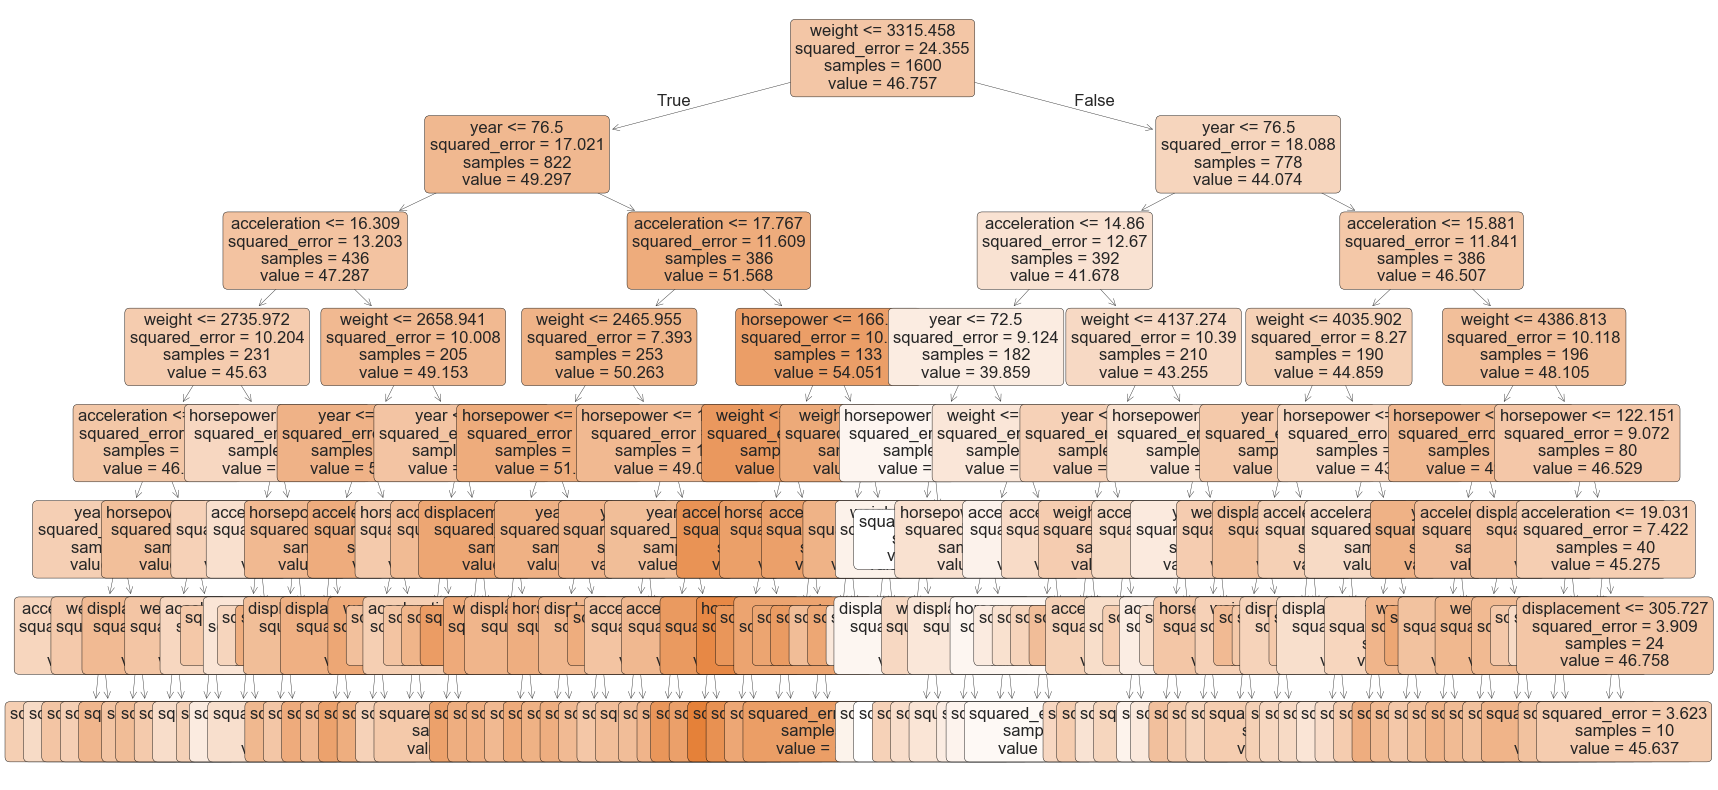

In [174]:
#Visualizacion del árbol 
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model_poda, feature_names=selected_features, filled=True, rounded=True, fontsize=12)
plt.show()


In [175]:
## Celda 8: Implementación de Red Neuronal
print("=== RED NEURONAL (MLP) ===")


# Probar diferentes arquitecturas
architectures = [
    (50,), (100,), (50, 25), (100, 50), (100, 50, 25)
]

best_architecture = None
best_score = float('-inf')


for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
    scores = cross_val_score(mlp_temp, X_train_scaled, y_train, cv=3, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_architecture = arch


print(f"Mejor arquitectura encontrada: {best_architecture}")

# Entrenar modelo final
mlp_model = MLPRegressor(
    hidden_layer_sizes=best_architecture,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)

# Métricas
mlp_train_mse = mean_squared_error(y_train, y_pred_mlp_train)
mlp_test_mse = mean_squared_error(y_test, y_pred_mlp_test)
mlp_train_r2 = r2_score(y_train, y_pred_mlp_train)
mlp_test_r2 = r2_score(y_test, y_pred_mlp_test)

print(f"MSE Entrenamiento: {mlp_train_mse:.4f}")
print(f"MSE Prueba: {mlp_test_mse:.4f}")
print(f"R² Entrenamiento: {mlp_train_r2:.4f}")
print(f"R² Prueba: {mlp_test_r2:.4f}")
print(f"Número de iteraciones: {mlp_model.n_iter_}")



=== RED NEURONAL (MLP) ===
Mejor arquitectura encontrada: (50, 25)
MSE Entrenamiento: 3.8174
MSE Prueba: 4.8723
R² Entrenamiento: 0.8433
R² Prueba: 0.8012
Número de iteraciones: 338


In [176]:
print('''
Se entrenó una red neuronal con diferentes arquitecturas y se seleccionó automáticamente la mejor, que resultó ser (50, 25).
Los resultados muestran un buen ajuste del modelo:
El R² en entrenamiento fue 0.84 y en prueba 0.80, lo que indica buena capacidad de generalización.
La diferencia entre ambos R² no sugiere un sobreajuste severo.
El modelo convergió en 338 iteraciones, gracias al uso de early stopping, evitando un entrenamiento innecesario o inestable.''')


Se entrenó una red neuronal con diferentes arquitecturas y se seleccionó automáticamente la mejor, que resultó ser (50, 25).
Los resultados muestran un buen ajuste del modelo:
El R² en entrenamiento fue 0.84 y en prueba 0.80, lo que indica buena capacidad de generalización.
La diferencia entre ambos R² no sugiere un sobreajuste severo.
El modelo convergió en 338 iteraciones, gracias al uso de early stopping, evitando un entrenamiento innecesario o inestable.


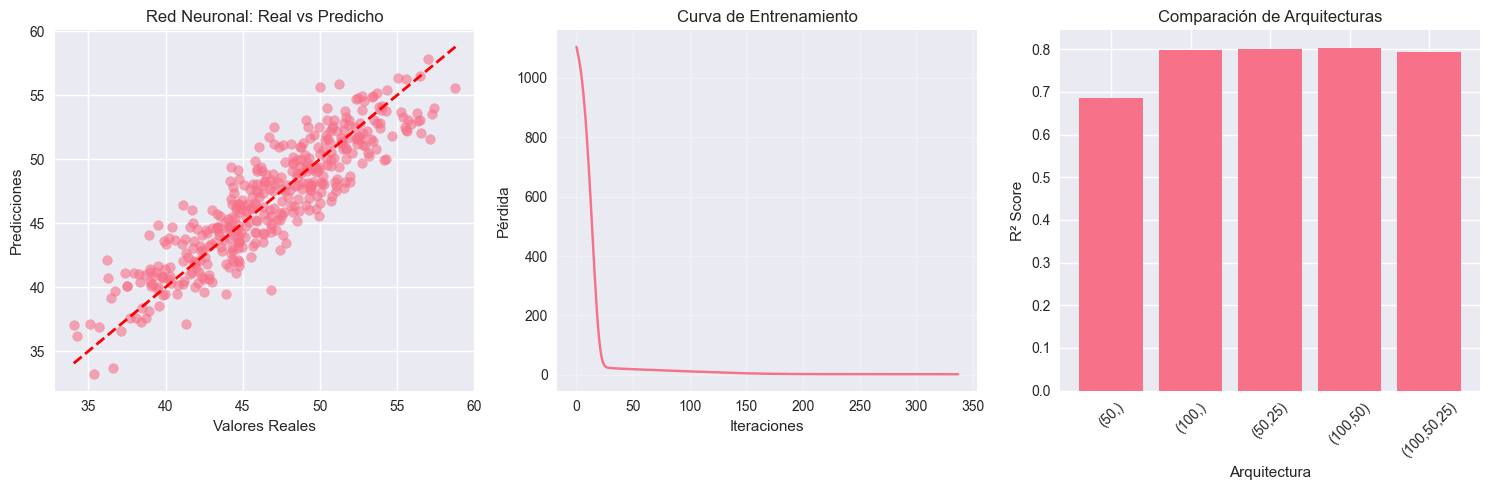

In [177]:
## Celda 9: Análisis de Red Neuronal
# Visualización de resultados
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_mlp_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Red Neuronal: Real vs Predicho')

# Gráfico 2: Curva de pérdida
plt.subplot(1, 3, 2)
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.title('Curva de Entrenamiento')
plt.grid(True, alpha=0.3)


# Gráfico 3: Comparación de arquitecturas
plt.subplot(1, 3, 3)
arch_names = ['(50,)', '(100,)', '(50,25)', '(100,50)', '(100,50,25)']
arch_scores = []
for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=500,
        random_state=42
    )
    mlp_temp.fit(X_train_scaled, y_train)
    score = r2_score(y_test, mlp_temp.predict(X_test_scaled))
    arch_scores.append(score)

plt.bar(arch_names, arch_scores)
plt.xlabel('Arquitectura')
plt.ylabel('R² Score')
plt.title('Comparación de Arquitecturas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




In [178]:
print("Analisis de la curva de entrenamiento")
print('''
La curva de pérdida durante el entrenamiento muestra un descenso claro y constante desde un valor inicial alto (alrededor de 1100) hasta un valor mucho más bajo (aproximadamente 1.89). 
Esto indica que el modelo ha logrado minimizar exitosamente la función de pérdida a medida que avanzan las iteraciones.
No se observan oscilaciones grandes ni estancamientos bruscos, lo que sugiere un proceso de aprendizaje estable y progresivo.
El hecho de que la pérdida final sea baja y que la curva se estabilice es una buena señal de que el modelo logró converger correctamente, evitando problemas de sobreajuste evidentes en esta etapa.''')
print("-" * 80)
print("Estrategias para prevenir el overfitting")
print('''
Para prevenir el sobreajuste en la red neuronal se utilizaron varias estrategias.
En primer lugar, se aplicó early stopping, que detiene el entrenamiento cuando la pérdida en el conjunto de validación deja de mejorar, evitando un entrenamiento excesivo.
Además, se normalizaron los datos antes de entrenar, lo cual mejora la estabilidad del aprendizaje. 
También se evaluaron distintas arquitecturas mediante validación cruzada, lo que permitió seleccionar un modelo adecuado en términos de complejidad y desempeño general, reduciendo el riesgo de sobreajuste.
   ''' )

Analisis de la curva de entrenamiento

La curva de pérdida durante el entrenamiento muestra un descenso claro y constante desde un valor inicial alto (alrededor de 1100) hasta un valor mucho más bajo (aproximadamente 1.89). 
Esto indica que el modelo ha logrado minimizar exitosamente la función de pérdida a medida que avanzan las iteraciones.
No se observan oscilaciones grandes ni estancamientos bruscos, lo que sugiere un proceso de aprendizaje estable y progresivo.
El hecho de que la pérdida final sea baja y que la curva se estabilice es una buena señal de que el modelo logró converger correctamente, evitando problemas de sobreajuste evidentes en esta etapa.
--------------------------------------------------------------------------------
Estrategias para prevenir el overfitting

Para prevenir el sobreajuste en la red neuronal se utilizaron varias estrategias.
En primer lugar, se aplicó early stopping, que detiene el entrenamiento cuando la pérdida en el conjunto de validación deja de 

In [179]:
## Celda 10: Comparación de Rendimiento
print("=== COMPARACIÓN DE MÉTODOS ===")


# Métricas del árbol podado
y_pred_tree_poda_train = tree_model_poda.predict(X_train)
y_pred_tree_poda_test = tree_model_poda.predict(X_test)

tree_poda_train_mse = mean_squared_error(y_train, y_pred_tree_poda_train)
tree_poda_test_mse = mean_squared_error(y_test, y_pred_tree_poda_test)
tree_poda_train_r2 = r2_score(y_train, y_pred_tree_poda_train)
tree_poda_test_r2 = r2_score(y_test, y_pred_tree_poda_test)
tree_poda_mae = mean_absolute_error(y_test, y_pred_tree_poda_test)


models = ['Regresión Lineal Múltiple', 'Árbol Podado', 'Red Neuronal']
train_mse = [lr_train_mse, tree_poda_train_mse, mlp_train_mse]
test_mse = [lr_test_mse, tree_poda_test_mse, mlp_test_mse]
train_r2 = [lr_train_r2, tree_poda_train_r2, mlp_train_r2]
test_r2 = [lr_test_r2, tree_poda_test_r2, mlp_test_r2]



# Calcular MAE adicional
lr_mae = mean_absolute_error(y_test, y_pred_lr_test)
tree_mae = mean_absolute_error(y_test, y_pred_tree_test)
mlp_mae = mean_absolute_error(y_test, y_pred_mlp_test)
test_mae = [lr_mae, tree_mae, mlp_mae]


comparison_df = pd.DataFrame({
    'Modelo': models,
    'MSE_Train': train_mse,
    'MSE_Test': test_mse,
    'R²_Train': train_r2,
    'R²_Test': test_r2,
    'MAE_Test': test_mae
})



print(comparison_df.round(4))


# Identificar mejor modelo
best_model_idx = np.argmax(test_r2)
print(f"\nMejor modelo por R² en prueba: {models[best_model_idx]}")
print(f"R² = {test_r2[best_model_idx]:.4f}")

=== COMPARACIÓN DE MÉTODOS ===
                      Modelo  MSE_Train  MSE_Test  R²_Train  R²_Test  MAE_Test
0  Regresión Lineal Múltiple     3.9270    4.3027    0.8388   0.8244    1.6855
1               Árbol Podado     3.9592    7.5627    0.8374   0.6914    2.3615
2               Red Neuronal     3.8174    4.8723    0.8433   0.8012    1.7956

Mejor modelo por R² en prueba: Regresión Lineal Múltiple
R² = 0.8244


In [180]:
print("COMPARACIÓN DE RENDIMIENTO")
print('''
Comparamos: Regresión lineal múltiple, árbol de decisión con poda previa y una red neuronal (MLP). 
Para esto, se utilizaron métricas estándar como el error cuadrático medio (MSE), el coeficiente de determinación (R²) y el error absoluto medio (MAE), tanto en el conjunto de entrenamiento como en el de prueba.
      
La regresión lineal obtuvo el mejor desempeño global, con un R² en prueba de 0.8244, lo que indica que explica más del 82% de la variabilidad de los datos. Además, presentó un bajo error de prueba (MSE = 4.3027) y el MAE más bajo (1.6855), mostrando un buen equilibrio entre ajuste y capacidad de generalización.

La red neuronal (MLP) también logró un buen rendimiento (R² = 0.8012), pero su error fue un poco mayor y requiere más complejidad computacional. 

El árbol de regresión podado fue el modelo con peor desempeño en prueba (R² = 0.6914, MSE = 7.5627), a pesar de aplicar técnicas para evitar el sobreajuste como la poda. Esto sugiere que el modelo perdió capacidad predictiva frente a los otros enfoques.

Dado su buen rendimiento, al momento se recomienda utilizar la regresión lineal múltiple para predecir el consumo de combustible (MPG) en este conjunto de datos.
      
      
Seguiremos testeando estos tres modelos a continuacion.''')

COMPARACIÓN DE RENDIMIENTO

Comparamos: Regresión lineal múltiple, árbol de decisión con poda previa y una red neuronal (MLP). 
Para esto, se utilizaron métricas estándar como el error cuadrático medio (MSE), el coeficiente de determinación (R²) y el error absoluto medio (MAE), tanto en el conjunto de entrenamiento como en el de prueba.

La regresión lineal obtuvo el mejor desempeño global, con un R² en prueba de 0.8244, lo que indica que explica más del 82% de la variabilidad de los datos. Además, presentó un bajo error de prueba (MSE = 4.3027) y el MAE más bajo (1.6855), mostrando un buen equilibrio entre ajuste y capacidad de generalización.

La red neuronal (MLP) también logró un buen rendimiento (R² = 0.8012), pero su error fue un poco mayor y requiere más complejidad computacional. 

El árbol de regresión podado fue el modelo con peor desempeño en prueba (R² = 0.6914, MSE = 7.5627), a pesar de aplicar técnicas para evitar el sobreajuste como la poda. Esto sugiere que el modelo pe

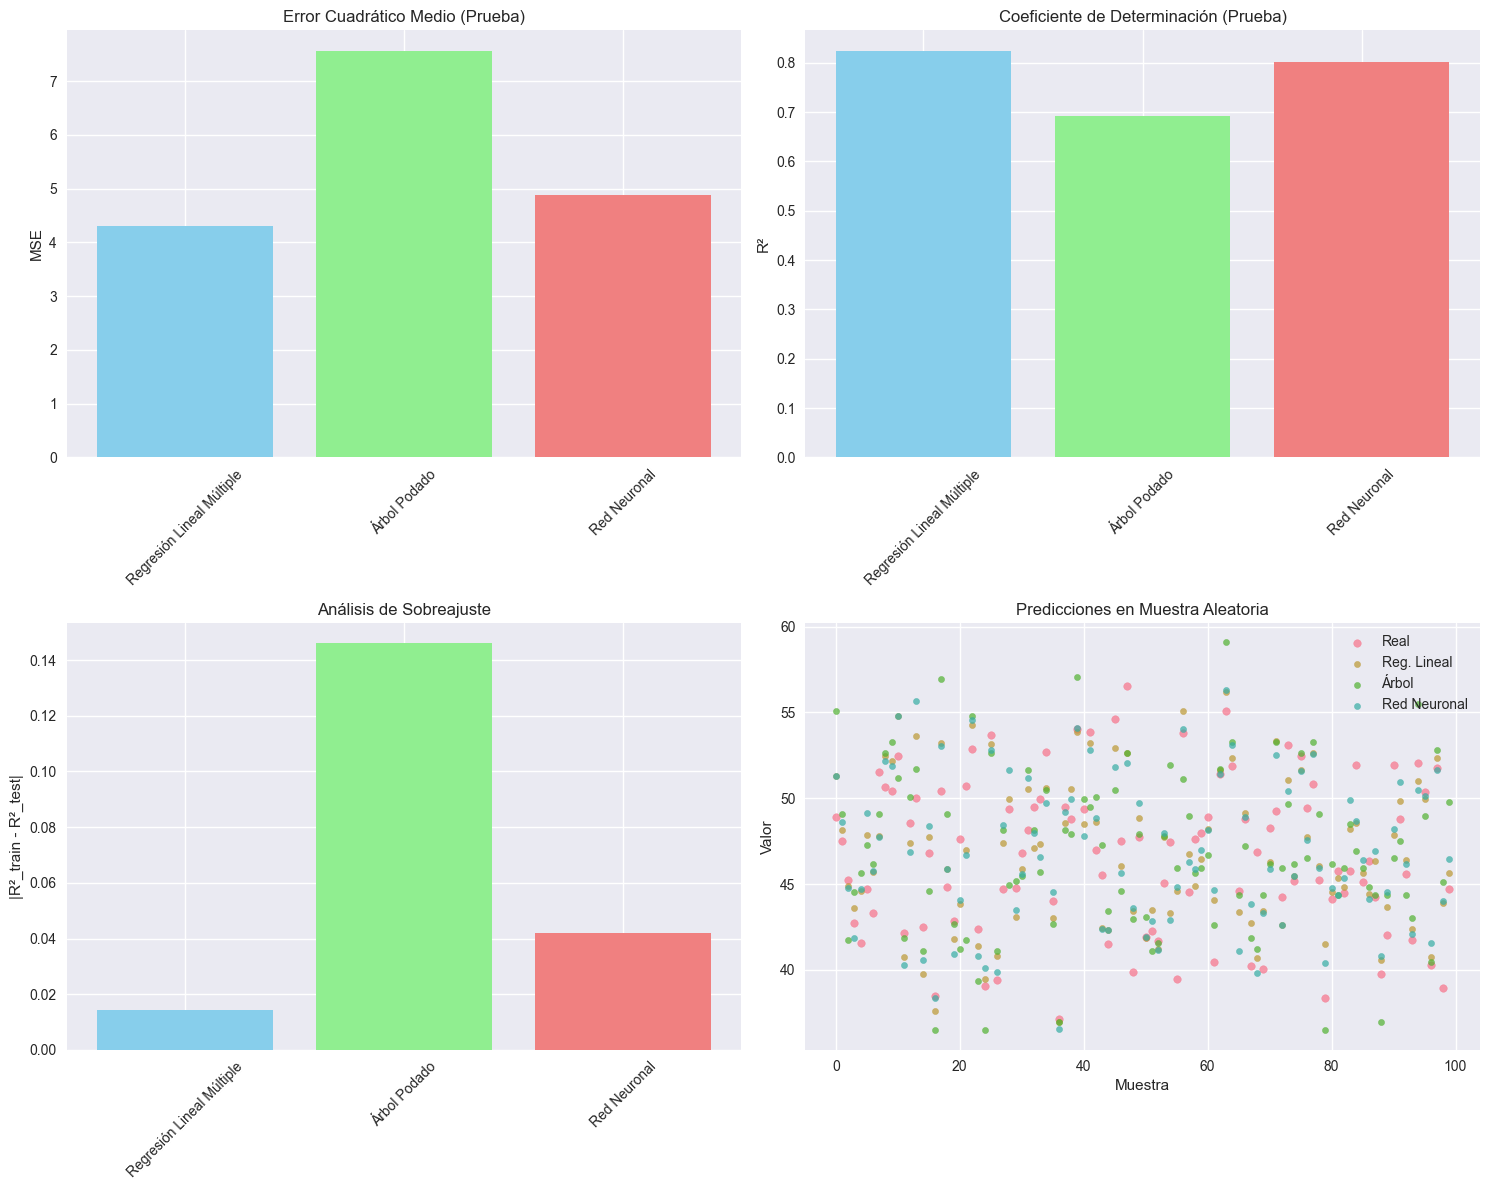

In [181]:
## Celda 11: Visualización Comparativa
# Gráficos de comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: MSE Comparación
axes[0, 0].bar(models, test_mse, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Error Cuadrático Medio (Prueba)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: R² Comparación
axes[0, 1].bar(models, test_r2, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('Coeficiente de Determinación (Prueba)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gráfico 3: Overfitting análisis
overfitting = [abs(train_r2[i] - test_r2[i]) for i in range(3)]
axes[1, 0].bar(models, overfitting, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_ylabel('|R²_train - R²_test|')
axes[1, 0].set_title('Análisis de Sobreajuste')
axes[1, 0].tick_params(axis='x', rotation=45)


# Gráfico 4: Predicciones comparativas
sample_indices = np.random.choice(len(y_test), 100, replace=False)
x_pos = np.arange(len(sample_indices))

axes[1, 1].scatter(x_pos, y_test.iloc[sample_indices], alpha=0.7, label='Real', s=30)
axes[1, 1].scatter(x_pos, y_pred_lr_test[sample_indices], alpha=0.7, label='Reg. Lineal', s=20)
axes[1, 1].scatter(x_pos, y_pred_tree_test[sample_indices], alpha=0.7, label='Árbol', s=20)
axes[1, 1].scatter(x_pos, y_pred_mlp_test[sample_indices], alpha=0.7, label='Red Neuronal', s=20)
axes[1, 1].set_xlabel('Muestra')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].set_title('Predicciones en Muestra Aleatoria')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

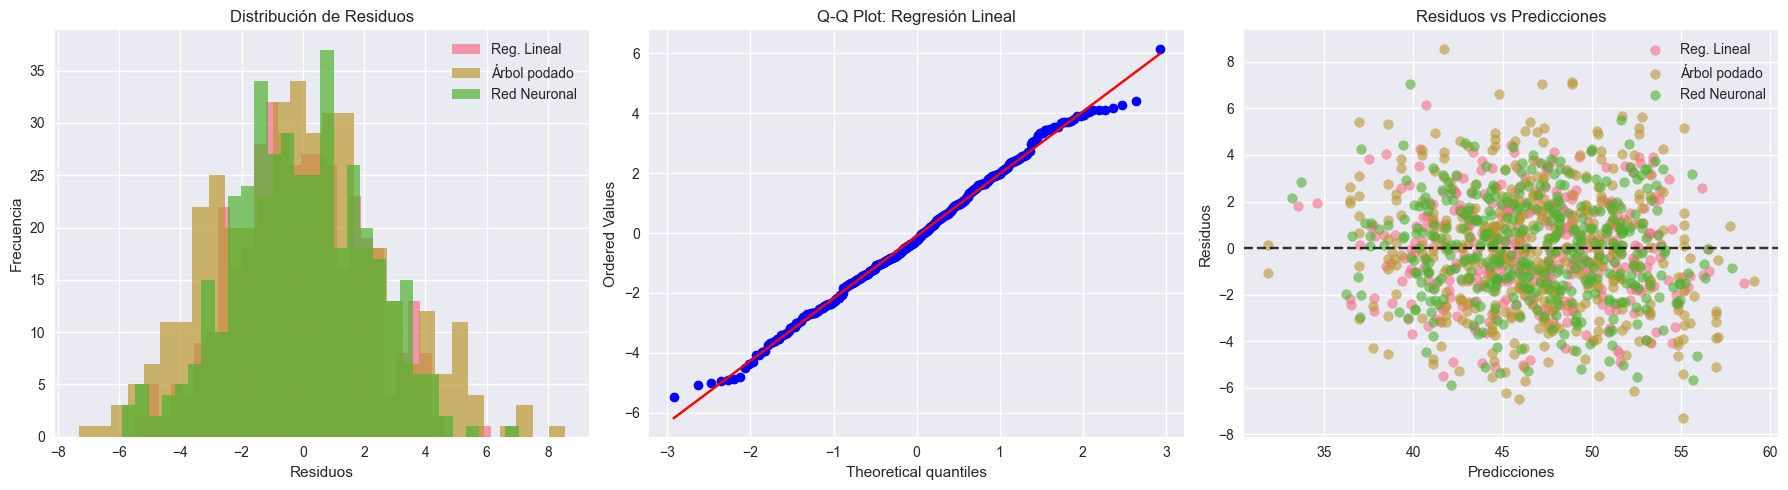

In [182]:
## Celda 12: Análisis de Residuos Comparativo
# Análisis detallado de residuos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuos de cada modelo
residuals_lr = y_test - y_pred_lr_test
residuals_tree = y_test - y_pred_tree_poda_test
residuals_mlp = y_test - y_pred_mlp_test

# Histogramas de residuos
axes[0].hist(residuals_lr, bins=30, alpha=0.7, label='Reg. Lineal')
axes[0].hist(residuals_tree, bins=30, alpha=0.7, label='Árbol podado')
axes[0].hist(residuals_mlp, bins=30, alpha=0.7, label='Red Neuronal')
axes[0].set_xlabel('Residuos')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')
axes[0].legend()

# Q-Q plot para normalidad (solo regresión lineal)
from scipy import stats
stats.probplot(residuals_lr, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Regresión Lineal')

# Residuos vs predicciones
axes[2].scatter(y_pred_lr_test, residuals_lr, alpha=0.6, label='Reg. Lineal')
axes[2].scatter(y_pred_tree_test, residuals_tree, alpha=0.6, label='Árbol podado')
axes[2].scatter(y_pred_mlp_test, residuals_mlp, alpha=0.6, label='Red Neuronal')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Residuos')
axes[2].set_title('Residuos vs Predicciones')
axes[2].legend()

plt.tight_layout()
plt.show()

In [183]:
print("Analisis de Residuos")
print('''
En el gráfico de distribución de residuos, se observa que los errores se concentran en torno al cero y presentan una forma aproximadamente simétrica en los tres casos, lo cual es un buen indicio de ajuste. 

El Q-Q plot correspondiente a la Regresión Lineal muestra una alineación bastante cercana entre los cuantiles teóricos y los observados, lo que indica que los residuos siguen razonablemente una distribución normal, con algunas pequeñas desviaciones en las colas. 

Por otro lado, en el gráfico de residuos vs predicciones, no se identifican patrones claros en ninguno de los modelos.''')

Analisis de Residuos

En el gráfico de distribución de residuos, se observa que los errores se concentran en torno al cero y presentan una forma aproximadamente simétrica en los tres casos, lo cual es un buen indicio de ajuste. 

El Q-Q plot correspondiente a la Regresión Lineal muestra una alineación bastante cercana entre los cuantiles teóricos y los observados, lo que indica que los residuos siguen razonablemente una distribución normal, con algunas pequeñas desviaciones en las colas. 

Por otro lado, en el gráfico de residuos vs predicciones, no se identifican patrones claros en ninguno de los modelos.


=== ANÁLISIS POR SEGMENTOS ===
  Segmento  Tamaño  Reg_Lineal_R2  Arbol_R2  Red_Neuronal_R2
0     Bajo     133         0.2997   -0.1877           0.2494
1    Medio     134        -0.9983   -1.7379          -1.3217
2     Alto     133         0.1093   -0.9623          -0.0394


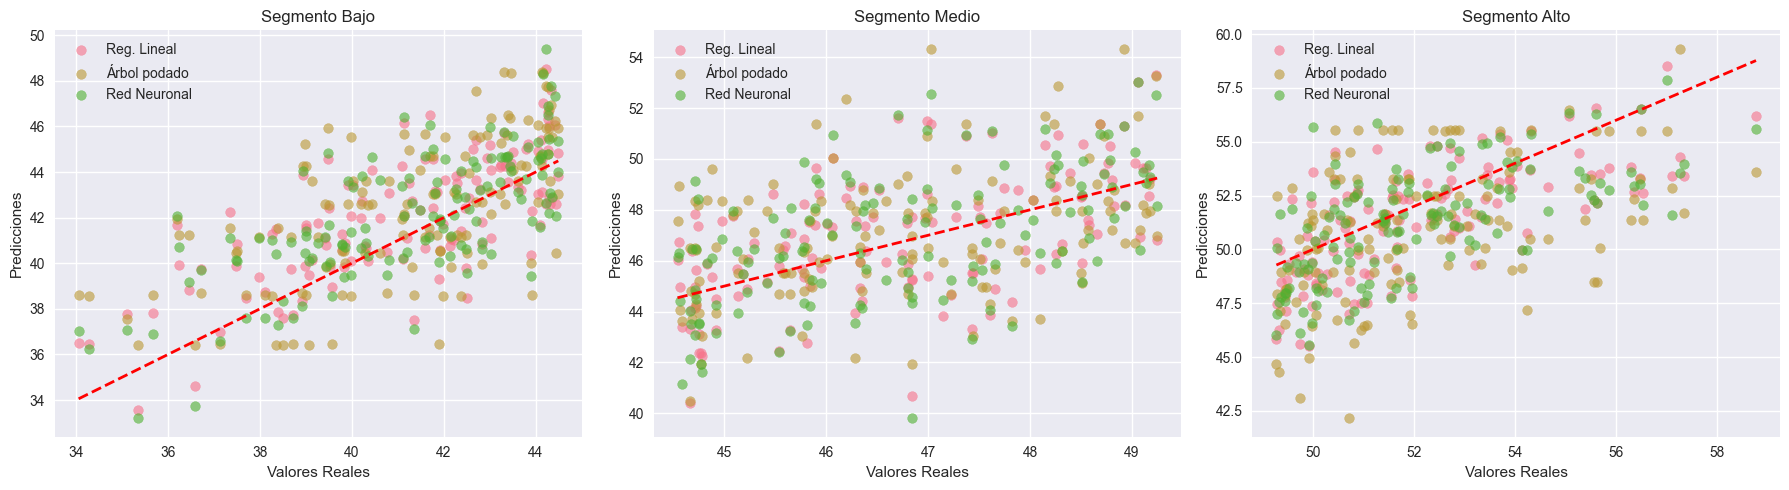

In [185]:
## Celda 13: Análisis de Segmentos de Datos
# Análisis por rangos de la variable objetivo
print("=== ANÁLISIS POR SEGMENTOS ===")

# Dividir datos en terciles
y_test_array = y_test.values
terciles = np.percentile(y_test_array, [33.33, 66.67])
low_mask = y_test_array < terciles[0]
mid_mask = (y_test_array >= terciles[0]) & (y_test_array < terciles[1])
high_mask = y_test_array >= terciles[1]

segments = ['Bajo', 'Medio', 'Alto']
masks = [low_mask, mid_mask, high_mask]


# Calcular métricas por segmento
segment_results = []
for i, mask in enumerate(masks):
    if np.sum(mask) > 0:
        lr_r2 = r2_score(y_test_array[mask], y_pred_lr_test[mask])
        tree_r2 = r2_score(y_test_array[mask], y_pred_tree_poda_test[mask])
        mlp_r2 = r2_score(y_test_array[mask], y_pred_mlp_test[mask])
        
        segment_results.append({
            'Segmento': segments[i],
            'Tamaño': np.sum(mask),
            'Reg_Lineal_R2': lr_r2,
            'Arbol_R2': tree_r2,
            'Red_Neuronal_R2': mlp_r2
        })


segment_df = pd.DataFrame(segment_results)
print(segment_df.round(4))


# Visualización por segmentos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (segment, mask) in enumerate(zip(segments, masks)):
    if np.sum(mask) > 0:
        axes[i].scatter(y_test_array[mask], y_pred_lr_test[mask], alpha=0.6, label='Reg. Lineal')
        axes[i].scatter(y_test_array[mask], y_pred_tree_poda_test[mask], alpha=0.6, label='Árbol podado')
        axes[i].scatter(y_test_array[mask], y_pred_mlp_test[mask], alpha=0.6, label='Red Neuronal')
        axes[i].plot([y_test_array[mask].min(), y_test_array[mask].max()], 
                    [y_test_array[mask].min(), y_test_array[mask].max()], 'r--', lw=2)
        axes[i].set_xlabel('Valores Reales')
        axes[i].set_ylabel('Predicciones')
        axes[i].set_title(f'Segmento {segment}')
        axes[i].legend()

plt.tight_layout()
plt.show()

In [186]:
print("Analisis de rendimiento en diferentes rangos")

print('''
Al segmentar los datos en terciles según el valor objetivo, se observa que:
      
#Segmento Bajo: La regresión lineal presenta un desempeño aceptable con un R^2 de aproximadamente 0.30, superando claramente a los otros modelos. 
Tanto el árbol como la red neuronal obtienen valores negativos, reflejando un mal ajuste en esta zona.

Segmento Medio: Ninguno de los modelos logra un buen desempeño en este rango, con R^2 fuertemente negativos, lo que indica que la predicción es peor que simplemente usar la media.

Segmento Alto: La regresión lineal mantiene un rendimiento superior al resto, con un R^2 positivo pero bajo (~0.11). 
El árbol y la red neuronal continúan con valores negativos, mostrando dificultades para modelar los valores más altos.

En conclusión, la regresión lineal es el modelo que mejor se adapta a los datos en los segmentos bajo y alto.''')

Analisis de rendimiento en diferentes rangos

Al segmentar los datos en terciles según el valor objetivo, se observa que:

#Segmento Bajo: La regresión lineal presenta un desempeño aceptable con un R^2 de aproximadamente 0.30, superando claramente a los otros modelos. 
Tanto el árbol como la red neuronal obtienen valores negativos, reflejando un mal ajuste en esta zona.

Segmento Medio: Ninguno de los modelos logra un buen desempeño en este rango, con R^2 fuertemente negativos, lo que indica que la predicción es peor que simplemente usar la media.

Segmento Alto: La regresión lineal mantiene un rendimiento superior al resto, con un R^2 positivo pero bajo (~0.11). 
El árbol y la red neuronal continúan con valores negativos, mostrando dificultades para modelar los valores más altos.

En conclusión, la regresión lineal es el modelo que mejor se adapta a los datos en los segmentos bajo y alto.


In [187]:
## Celda 14: Validación Cruzada Completa
print("=== VALIDACIÓN CRUZADA COMPLETA ===")

from sklearn.model_selection import cross_validate

# Definir métricas para evaluación
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Validación cruzada para cada modelo
models_cv = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Regresión': tree_model_poda ,  # Usar el árbol podado
    'Red Neuronal': MLPRegressor(hidden_layer_sizes=best_architecture, max_iter=500, random_state=42)
}

cv_results = {}
for name, model in models_cv.items():
    if name == 'Red Neuronal':
        # Para red neuronal usar datos escalados
        scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring)
    else:
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    cv_results[name] = {
        'R2': scores['test_r2'].mean(),
        'R2_std': scores['test_r2'].std(),
        'MSE': -scores['test_neg_mean_squared_error'].mean(),
        'MSE_std': scores['test_neg_mean_squared_error'].std(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'MAE_std': scores['test_neg_mean_absolute_error'].std()
    }


# Mostrar resultados
cv_df = pd.DataFrame(cv_results).T
print("Resultados de Validación Cruzada (5-fold):")
print(cv_df.round(4))

=== VALIDACIÓN CRUZADA COMPLETA ===
Resultados de Validación Cruzada (5-fold):
                        R2  R2_std     MSE  MSE_std     MAE  MAE_std
Regresión Lineal    0.8363  0.0225  3.9591   0.4025  1.5828   0.0876
Árbol de Regresión  0.7007  0.0335  7.2425   0.5336  2.1636   0.0666
Red Neuronal        0.8168  0.0248  4.4290   0.4184  1.6915   0.0980


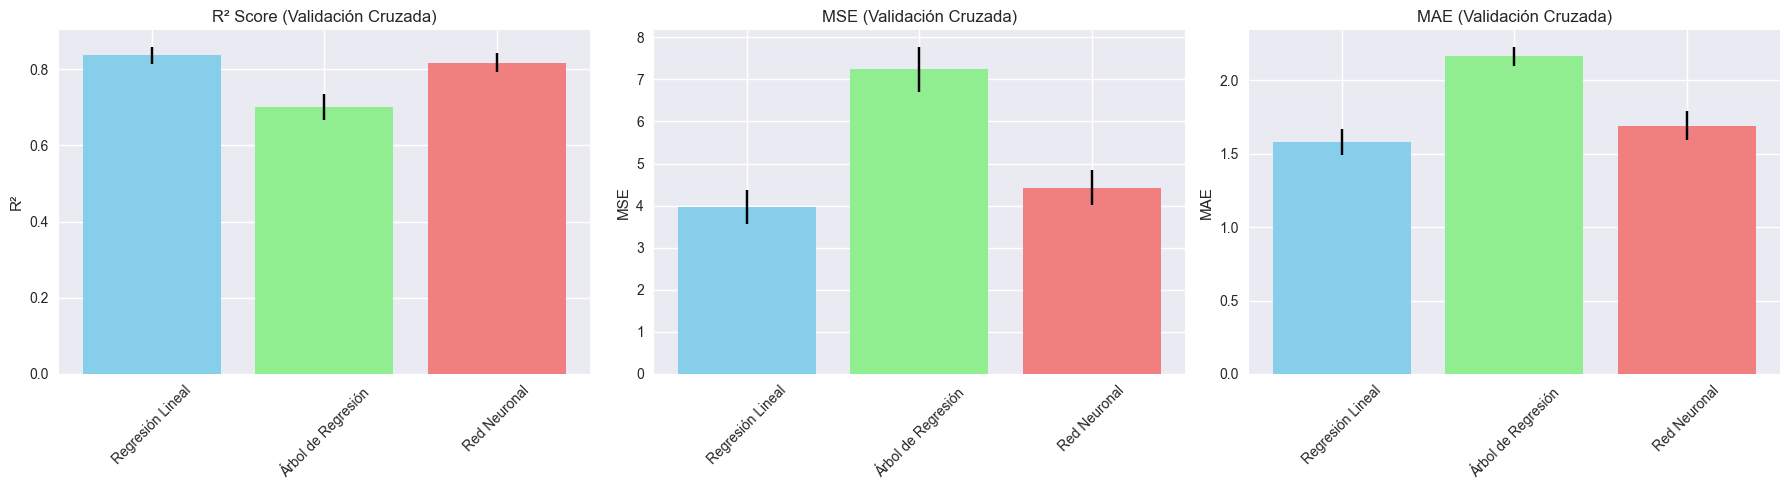

In [188]:
# Gráfico de barras con intervalos de confianza
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_names = list(cv_results.keys())
r2_means = [cv_results[name]['R2'] for name in models_names]
r2_stds = [cv_results[name]['R2_std'] for name in models_names]

mse_means = [cv_results[name]['MSE'] for name in models_names]
mse_stds = [cv_results[name]['MSE_std'] for name in models_names]

# R² con intervalos de confianza
axes[0].bar(models_names, r2_means, yerr=r2_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_ylabel('R²')
axes[0].set_title('R² Score (Validación Cruzada)')
axes[0].tick_params(axis='x', rotation=45)

# MSE con intervalos de confianza
axes[1].bar(models_names, mse_means, yerr=mse_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE (Validación Cruzada)')
axes[1].tick_params(axis='x', rotation=45)

# Calcular MAE y su desviación estándar
mae_means = [cv_results[name]['MAE'] for name in models_names]
mae_stds = [cv_results[name]['MAE_std'] for name in models_names]

# MAE con intervalos de confianza
axes[2].bar(models_names, mae_means, yerr=mae_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE (Validación Cruzada)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [189]:
print("Comparación estadística")
print('''
Los gráficos incluyen intervalos de confianza construidos a partir de la desviación estándar de los resultados en cada partición. 
La comparación de los intervalos cumple una función equivalente a la de un test de significancia, permitiendo inferir si las diferencias observadas entre modelos podrían considerarse relevantes desde el punto de vista estadístico. 
En este caso, los intervalos del Árbol Podado no se superponen con los de los otros modelos en MSE y MAE, lo que sugiere una diferencia significativa en el rendimiento. 
En cambio, la superposición parcial entre la Regresión Lineal y la Red Neuronal indica que sus desempeños son comparables dentro del margen de error observado.''')

Comparación estadística

Los gráficos incluyen intervalos de confianza construidos a partir de la desviación estándar de los resultados en cada partición. 
La comparación de los intervalos cumple una función equivalente a la de un test de significancia, permitiendo inferir si las diferencias observadas entre modelos podrían considerarse relevantes desde el punto de vista estadístico. 
En este caso, los intervalos del Árbol Podado no se superponen con los de los otros modelos en MSE y MAE, lo que sugiere una diferencia significativa en el rendimiento. 
En cambio, la superposición parcial entre la Regresión Lineal y la Red Neuronal indica que sus desempeños son comparables dentro del margen de error observado.


In [190]:
# === TEST DE FRIEDMAN PARA COMPARACIÓN DE MODELOS ===
# Lo elijo pues:
# Estamos comparando TRES modelos (más de dos)
# Cada modelo fue evaluado en los mismos 5 folds (mediciones repetidas)


# Obtener R² de cada modelo en cada fold (validación cruzada)
lr_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='r2')
tree_scores = cross_val_score(DecisionTreeRegressor(max_depth=best_depth, random_state=42), X_train, y_train, cv=5, scoring='r2')
mlp_scores = cross_val_score(MLPRegressor(hidden_layer_sizes=best_architecture, max_iter=500, random_state=42), X_train_scaled, y_train, cv=5, scoring='r2')

# Aplicar test de Friedman
stat, p = friedmanchisquare(lr_scores, tree_scores, mlp_scores)

# Mostrar resultados
print("=== TEST DE FRIEDMAN ===")
print(f"Estadístico de Friedman: {stat:.4f}")
print(f"Valor p: {p:.4f}")

if p < 0.05:
    print("→ Hay diferencias estadísticamente significativas entre al menos dos modelos.")
else:
    print("→ No se detectaron diferencias significativas entre los modelos.")

=== TEST DE FRIEDMAN ===
Estadístico de Friedman: 10.0000
Valor p: 0.0067
→ Hay diferencias estadísticamente significativas entre al menos dos modelos.


In [191]:
print("Se realizó un test de significancia estadística")

print('''
Para evaluar si las diferencias en el rendimiento de los modelos observadas durante la validación cruzada eran estadísticamente significativas, se aplicó el test de Friedman.
Este test no paramétrico es apropiado cuando se comparan tres o más modelos evaluados sobre los mismos subconjuntos de datos (en este caso, los 5 folds de la validación cruzada), sin asumir normalidad en las diferencias de rendimiento.
El test se aplicó sobre las puntuaciones de R^2 obtenidas por los modelos de regresión lineal, árbol de regresión y red neuronal. 
Dado que el valor p es menor a 0.05, se concluye que existen diferencias estadísticamente significativas entre al menos dos de los modelos evaluados. 
Esto respalda la interpretación de que no todos los modelos tienen un desempeño equivalente, lo que justifica la comparación detallada y la selección del mejor modelo según las métricas de rendimiento.''')

Se realizó un test de significancia estadística

Para evaluar si las diferencias en el rendimiento de los modelos observadas durante la validación cruzada eran estadísticamente significativas, se aplicó el test de Friedman.
Este test no paramétrico es apropiado cuando se comparan tres o más modelos evaluados sobre los mismos subconjuntos de datos (en este caso, los 5 folds de la validación cruzada), sin asumir normalidad en las diferencias de rendimiento.
El test se aplicó sobre las puntuaciones de R^2 obtenidas por los modelos de regresión lineal, árbol de regresión y red neuronal. 
Dado que el valor p es menor a 0.05, se concluye que existen diferencias estadísticamente significativas entre al menos dos de los modelos evaluados. 
Esto respalda la interpretación de que no todos los modelos tienen un desempeño equivalente, lo que justifica la comparación detallada y la selección del mejor modelo según las métricas de rendimiento.


In [192]:
## Celda 15: Conclusiones y Recomendaciones
print("=== CONCLUSIONES Y RECOMENDACIONES ===")

# Resumen final
print("\n📊 RESUMEN EJECUTIVO:")
print("="*50)

# Mejor modelo general
best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['R2'])
print(f"🏆 Mejor modelo (Validación Cruzada): {best_cv_model}")
print(f"   R² = {cv_results[best_cv_model]['R2']:.4f} ± {cv_results[best_cv_model]['R2_std']:.4f}")

# Análisis de complejidad vs rendimiento
print(f"\n📈 ANÁLISIS DE RENDIMIENTO:")
print(f"• Regresión Lineal: Simple, interpretable, R² = {cv_results['Regresión Lineal']['R2']:.4f}")
print(f"• Árbol de Regresión: Captura no-linealidades, R² = {cv_results['Árbol de Regresión']['R2']:.4f}")
print(f"• Red Neuronal: Más compleja, R² = {cv_results['Red Neuronal']['R2']:.4f}")
print("=" * 80)
print('''Se evaluaron tres modelos de regresión para predecir la variable objetivo: regresión lineal múltiple, árbol de regresión podado y red neuronal (MLP). La comparación se realizó utilizando métricas clásicas como el error cuadrático medio (MSE), el coeficiente de determinación (R²) y el error absoluto medio (MAE), tanto en los conjuntos de entrenamiento como de prueba, complementado con una validación cruzada de 5 folds para evaluar la estabilidad de los modelos.
En el conjunto de prueba, la regresión lineal múltiple fue el modelo con mejor desempeño, presentando un R² de 0.8244, lo que indica que explica aproximadamente el 82.44% de la variabilidad de los datos no vistos. Además, mostró un MSE de 4.3027 y un MAE de 1.6855, siendo estas las mejores métricas entre los tres modelos evaluados, reflejando predicciones más precisas y errores absolutos menores. La red neuronal quedó en segundo lugar con un R² de 0.8012, un MSE de 4.8723 y un MAE de 1.7956, lo que indica un rendimiento cercano pero ligeramente inferior al de la regresión lineal. Por último, el árbol de regresión podado mostró el desempeño más bajo, con un R² de 0.6914, un MSE significativamente mayor de 7.5627 y un MAE de 2.3615, reflejando menor capacidad para generalizar y mayor error en sus predicciones.
La validación cruzada de cinco folds corroboró estos resultados, confirmando la estabilidad y consistencia de los modelos.      
La regresión lineal multiple mantuvo el mejor promedio en R² (0.8363), el menor MSE (3.9591) y el menor MAE (1.5828), además de la menor desviación estándar en estas métricas, lo que indica que sus resultados son consistentes en diferentes subconjuntos del conjunto de entrenamiento.
La red neuronal presentó resultados similares, aunque con mayor variabilidad, mientras que el árbol de regresión fue nuevamente el menos efectivo, mostrando menor promedio de R² y mayor error y variabilidad.
Adicionalmente, se realizó un análisis segmentado dividiendo la variable objetivo en tres rangos según sus terciles: bajo, medio y alto. Los modelos mostraron un desempeño moderado en el segmento bajo, donde la regresión lineal logró un R² positivo cercano a 0.30 y la red neuronal también mostró un desempeño aceptable, mientras que el árbol no logró resultados satisfactorios.
Sin embargo, en los segmentos medio y alto, los tres modelos presentaron R² negativos, lo que indica que sus predicciones son peores que simplemente usar la media para esos rangos. Esto señala que los modelos actuales tienen limitaciones para capturar el comportamiento en valores medios y altos de la variable objetivo, lo que podría deberse a falta de datos representativos o a la necesidad de incorporar nuevas características o enfoques más complejos.

En resumen, la regresión lineal múltiple es el modelo más adecuado para este problema, ya que combina un alto poder explicativo, precisión en las predicciones y estabilidad. 
La red neuronal representa una alternativa válida con un rendimiento cercano, aunque con mayor variabilidad, mientras que el árbol podado presenta un desempeño inferior y es menos recomendable.
 ''')
print("=" * 80)
print('''
Limitaciones:     
A pesar de que la regresión lineal múltiple mostró el mejor desempeño general, existen varias limitaciones importantes en este estudio que conviene considerar. ' \
En primer lugar, el análisis segmentado reveló que ninguno de los modelos logra predecir bien los valores medios y altos de la variable objetivo, lo que indica que el modelo no captura adecuadamente la complejidad o no dispone de suficientes datos representativos en esos rangos.
Además, la selección de características y la calidad de los datos pueden afectar la capacidad predictiva. Si las variables usadas no representan suficientemente los factores que influyen en el objetivo, los modelos tendrán un rendimiento limitado, especialmente en casos no lineales o con interacciones complejas.
Por otro lado, el árbol de regresión podado mostró un desempeño inferior, lo que puede deberse a una poda demasiado agresiva o a que su capacidad para capturar patrones complejos fue limitada. ''')
print("="*50)
print('''
Para mejorar los resultados y la robustez de los modelos, se recomienda en primer lugar ampliar y diversificar el conjunto de datos, incluyendo más ejemplos especialmente en los segmentos medio y alto, donde los modelos actuales presentan un desempeño deficiente. 
Esto ayudaría a que los modelos puedan aprender mejor los patrones complejos y generalizar mejor.''')

=== CONCLUSIONES Y RECOMENDACIONES ===

📊 RESUMEN EJECUTIVO:
🏆 Mejor modelo (Validación Cruzada): Regresión Lineal
   R² = 0.8363 ± 0.0225

📈 ANÁLISIS DE RENDIMIENTO:
• Regresión Lineal: Simple, interpretable, R² = 0.8363
• Árbol de Regresión: Captura no-linealidades, R² = 0.7007
• Red Neuronal: Más compleja, R² = 0.8168
Se evaluaron tres modelos de regresión para predecir la variable objetivo: regresión lineal múltiple, árbol de regresión podado y red neuronal (MLP). La comparación se realizó utilizando métricas clásicas como el error cuadrático medio (MSE), el coeficiente de determinación (R²) y el error absoluto medio (MAE), tanto en los conjuntos de entrenamiento como de prueba, complementado con una validación cruzada de 5 folds para evaluar la estabilidad de los modelos.
En el conjunto de prueba, la regresión lineal múltiple fue el modelo con mejor desempeño, presentando un R² de 0.8244, lo que indica que explica aproximadamente el 82.44% de la variabilidad de los datos no vistos